In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib.patches import Ellipse, transforms
from scipy import stats
from scipy.special import expit as logistic
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline

In [ ]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [ ]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

In [ ]:
Mu = [a, b]

In [ ]:
cov_ab = sigma_a * sigma_b * rho
cov_ab

-0.35

In [ ]:
Sigma = np.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

In [ ]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])
sigmas, Rho

([1.0, 0.5],
 matrix([[ 1. , -0.7],
         [-0.7,  1. ]]))

In [ ]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

In [ ]:
N_cafes = 20

In [ ]:
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

In [ ]:
vary_effects

array([[ 3.63329985, -1.50959694],
       [ 2.86879493,  0.07433125],
       [ 3.66731436, -1.56161611],
       [ 1.07676391, -0.81212114],
       [ 3.06783998, -0.78308276],
       [ 3.77915906, -1.25024896],
       [ 1.64367718,  0.01268819],
       [ 3.43293817, -0.99533411],
       [ 3.93476785, -0.92904695],
       [ 3.43864561, -0.90337165],
       [ 2.52272377, -0.84514119],
       [ 3.69348394, -1.18935422],
       [ 2.87114338, -0.70985701],
       [ 3.06004675, -0.92828892],
       [ 4.19637163, -1.05191239],
       [ 3.95165135, -1.24407302],
       [ 4.22396308, -1.14782198],
       [ 4.12342823, -1.3780191 ],
       [ 2.75186554, -0.73776156],
       [ 3.51175764, -1.39692594]])

In [ ]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

In [ ]:
vary_effects.shape, a_cafe.shape, b_cafe.shape

((20, 2), (20,), (20,))

In [ ]:
np.linalg.eigh(Sigma)

(array([0.11204289, 1.13795711]),
 matrix([[-0.36670474, -0.93033738],
         [-0.93033738,  0.36670474]]))

In [ ]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

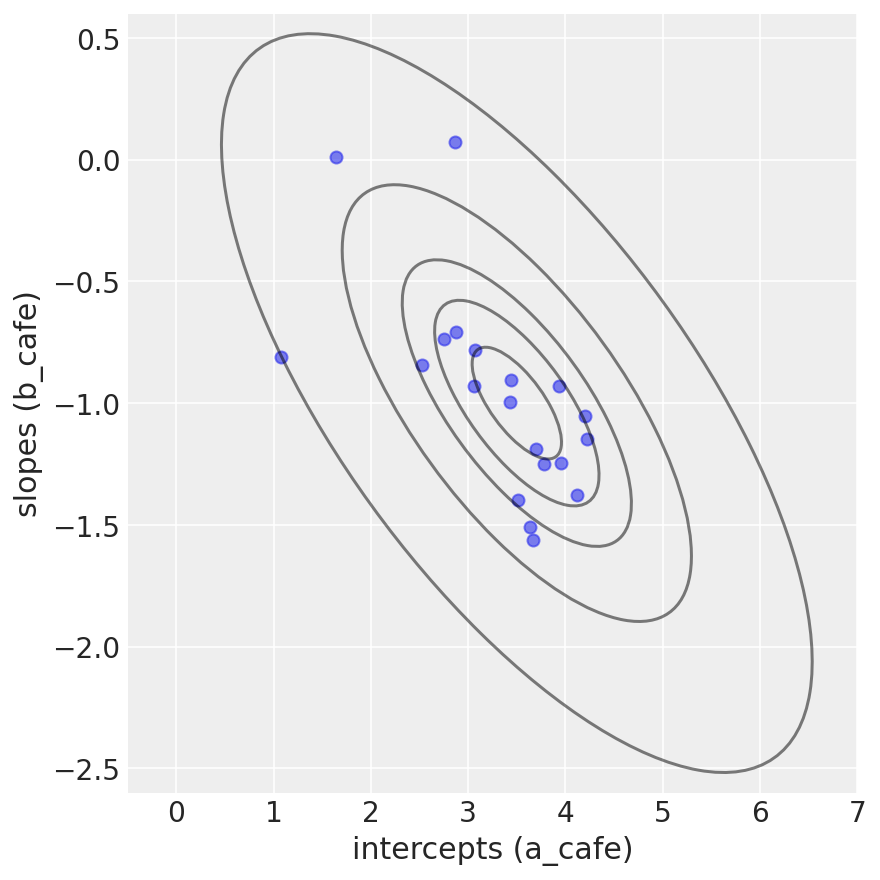

In [ ]:
ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

In [ ]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

,cafe,afternoon,wait
0,0,0,3.248747
1,0,1,2.354369
2,0,0,3.318056
3,0,1,1.485952
4,0,0,4.574328
...,...,...,...
195,19,1,2.175432
196,19,0,3.824848
197,19,1,1.465361
198,19,0,3.510865


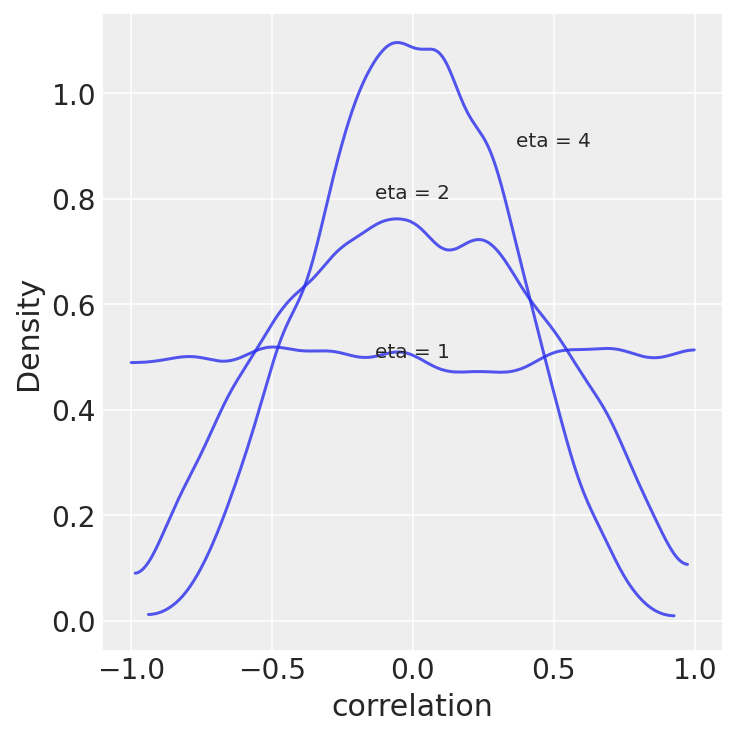

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    az.plot_kde(R, plot_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

In [ ]:
jkj = pm.LKJCorr.dist(n=2, eta=1)

In [ ]:
type(jkj)

pymc3.distributions.multivariate.LKJCorr

In [ ]:
with pm.Model():
    lk = pm.LKJCorr("lkj", n=2, eta=1)

In [ ]:
lk

lkj ~ LKJCorr